# Interaction wake-cylinder ($Re=40$)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ibmos as ib

## Numerical grid and solver initialization

In [3]:
passages = 1

In [4]:
s1 = ib.stretching(192, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
s2 = ib.stretching(64, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
x = np.concatenate([-s2[::-1], s1[1:]])

s = ib.stretching(31, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
y0 = np.concatenate([-s[::-1], s[1:]])

Ly = y0[-1] - y0[0]

y = np.concatenate([y0,] + [y0[1:] + k*Ly for k in range(1, passages) ])

solver = ib.Solver(x, y, periodic=True, iRe=1/40.0, Co=2*(y[-1]-y[0])/284*0.5/0.02) 

In [5]:
(len(y)-1)/3

20.0

## Immersed boundaries

In [6]:
solver.set_solids(*[ib.shapes.cylinder("cyl[%d]"%k, 0, k*Ly, 0.5, solver.dxmin) for k in range(passages)])

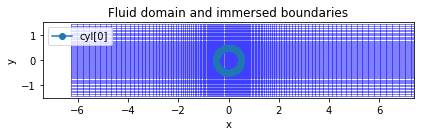

In [7]:
solver.plot_domain(figsize=(6, 2), xlim=(-4, 4), ylim=(-1.5, 1.5))

## Boundary conditions and initial condition

In [8]:
f = np.load('401-WakeCylinderUnsteady-X.npz')
X0, t0 = f['x0'], f['t0']

In [9]:
fuBC = (lambda s, t: 1.52-1.1*np.sin(np.pi*(s-y[0]-0.5*t)/(y[-1]-y[0]))**2,
        lambda s, t: 0.97*np.ones_like(s) )
fvBC = (lambda s, t: 0.04*np.sin(2*np.pi*(s-y[0]-0.5*t)/(y[-1]-y[0])),
        lambda s, t: np.zeros_like(s))

fsBC = ((lambda ξ, η, t: np.zeros_like(ξ),)*2, )

## Unsteady simulation

In [18]:
%%time 
X, t, infodict = solver.steps(X0, fuBC, fvBC, fsBC, t0=t0, outflowEast=True, 
                              saveEvery=1, number=284, verbose=284//8)

       k            t          x_2       dxdt_2    cyl[0]_fx    cyl[0]_fy  Uinf@outlet 
      35  9.07201e+01  1.59825e+02  3.95157e+01  3.08768e+00  1.36812e-01  9.70000e-01 
      70  9.14202e+01  1.50776e+02  3.37739e+01  3.27868e+00  2.27905e-01  9.70000e-01 
     105  9.21203e+01  1.48869e+02  2.42286e+01  3.53952e+00  1.79027e-01  9.70000e-01 
     140  9.28204e+01  1.54069e+02  3.37693e+01  3.69911e+00  1.94540e-02  9.70000e-01 
     175  9.35205e+01  1.63308e+02  3.50611e+01  3.67636e+00 -1.49291e-01  9.70000e-01 
     210  9.42206e+01  1.71457e+02  2.92506e+01  3.50170e+00 -2.31971e-01  9.70000e-01 
     245  9.49207e+01  1.74880e+02  2.49141e+01  3.26798e+00 -1.91115e-01  9.70000e-01 
     280  9.56208e+01  1.71226e+02  2.87095e+01  3.09248e+00 -5.05575e-02  9.70000e-01 
     284  9.57008e+01  1.70318e+02  2.98928e+01  3.08115e+00 -3.09189e-02  9.70000e-01 
CPU times: user 7min 46s, sys: 24.6 s, total: 8min 10s
Wall time: 20.2 s


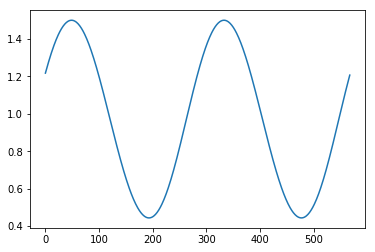

In [19]:
plt.plot(np.concatenate([ [Xk[0] for Xk in X], [Xk[0] for Xk in X] ]))

# Linearized forward integration!!

In [20]:
import scipy.sparse as sp

In [21]:
A, B = (M[0].tocsr() for M in solver.propagator(fractionalStep=False))
iA = solver.solver(A)[0]

In [181]:
x = [solver.zero(),]
x[0][:solver.pStart] = 2*np.random.random(solver.pStart) - 1

In [203]:
for it in range(40):
    print(it)
    x = [x[-1]/np.max(x[-1]), ]

    N = solver.fluid.linearized_advection(*solver.reshape(*solver.unpack(X[0]))[:2], 
                                          *solver.eval_uvBC(t0, fuBC, fvBC)).tocsr()
    N = sp.block_diag((N, sp.coo_matrix((A.shape[0] - N.shape[0],)*2)))
    x.append( iA((B-N)@x[0]) )

    Nm1 = N.copy()

    for k in range(2, 284):
        N = solver.fluid.linearized_advection(*solver.reshape(*solver.unpack(X[k-1]))[:2], 
                                              *solver.eval_uvBC(t0+(k-1)*solver.dt, fuBC, fvBC)).tocsr()
        N = sp.block_diag((N, sp.coo_matrix((A.shape[0] - N.shape[0],)*2)))

        x.append( iA( (B-1.5*N)@x[-1] + 0.5*Nm1@x[-2]) )

        Nm1 = N.copy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


# Linearized backwards integration!!

In [202]:
#λ = [solver.zero(),]
#λ[0][:solver.pStart] = 2*np.random.random(solver.pStart) - 1
for it in range(40):
    print(it)

    λ = [λ[-1]/np.max(λ[-1]), ]

    N = solver.fluid.linearized_advection(*solver.reshape(*solver.unpack(X[len(X)-1-1]))[:2], 
                                          *solver.eval_uvBC(t0+(len(X)-1-1)*solver.dt, fuBC, fvBC)).tocsr()
    N = sp.block_diag((N, sp.coo_matrix((A.shape[0] - N.shape[0],)*2)))

    iAλm2 = iA(λ[0])
    λ.append((B-1.5*N.T)@iAλm2)

    for j in range(2, len(X)):    
        N = solver.fluid.linearized_advection(*solver.reshape(*solver.unpack(X[len(X)-1-j]))[:2], 
                                          *solver.eval_uvBC(t0+(len(X)-1-j)*solver.dt, fuBC, fvBC)).tocsr()
        N = sp.block_diag((N, sp.coo_matrix((A.shape[0] - N.shape[0],)*2)))

        iAλm1 = iA(λ[-1])

        λ.append( (B-(1.0 if j==len(X)-1 else 1.5)*N.T)@iAλm1 + 0.5*N.T@iAλm2 )

        iAλm2 = iAλm1.copy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [184]:
λ[0]@x[-1]

1.9716878479860354

## Display results

Display velocity field and pressure at the last time step

In [204]:
from IPython.display import HTML
from matplotlib import animation
%config InlineBackend.figure_format = 'png'

<Figure size 432x288 with 0 Axes>

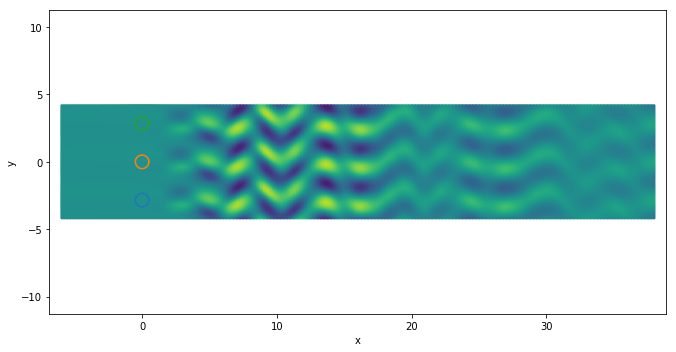

In [210]:
plt.figure()
fig, ax = plt.subplots(figsize=(9.5, 5))
Ly = (y[-1]-y[0])
quad = ax.pcolormesh(solver.fluid.u.x, 
                     np.r_[solver.fluid.u.y - Ly, solver.fluid.u.y, solver.fluid.u.y + Ly],
                     np.vstack([solver.reshape(*solver.unpack(x[0]))[0],]*3),
                     rasterized=True, shading='gouraud', vmin=-0.1, vmax=0.1)

for solid in solver.solids:
    plt.plot(solid.ξ, solid.η-Ly)
    plt.plot(solid.ξ, solid.η)
    plt.plot(solid.ξ, solid.η+Ly)
    
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-6, 38)
ax.set_ylim(-2, 2)
fig.tight_layout()

In [211]:
def init():
    quad.set_array([])
    return quad,

def animate(i):
    array = np.r_[solver.unpack(x[i])[0].ravel(), solver.unpack(x[i])[0].ravel(),solver.unpack(x[i])[0].ravel()]
    quad.set_array(array)
    return quad,

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=len(x), interval=15, blit=True)

In [212]:
%time HTML(anim.to_html5_video())

CPU times: user 58 s, sys: 239 ms, total: 58.2 s
Wall time: 58.6 s


(0, 5)

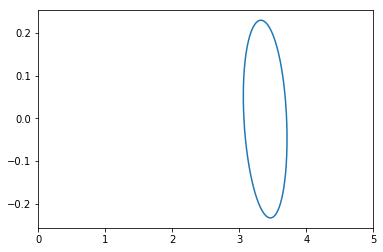

In [62]:
plt.plot(infodict['cyl[0]_fx'], infodict['cyl[0]_fy'])
plt.xlim(0, 5)

In [73]:
import scipy.linalg as la

In [90]:
μ=np.log(la.norm(x[-1])/la.norm(x[0]))/(284*solver.dt)

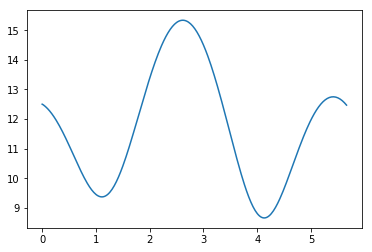

In [91]:
tt = np.arange(284)*solver.dt; plt.plot(tt, np.asarray([la.norm(xk) for xk in x])/np.exp(μ*tt))

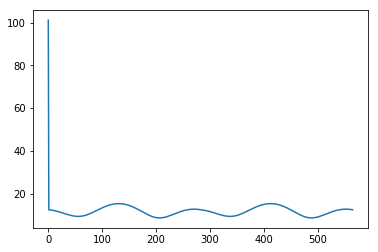

In [100]:
plt.plot(np.r_[np.asarray([la.norm(xk) for xk in x])/np.exp(μ*tt), np.asarray([la.norm(xk) for xk in x[2:]])/np.exp(μ*tt[2:])])